# 基本信息

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
import catboost as cb
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization#pip install bayesian-optimization
from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder
import eli5
from eli5.sklearn import PermutationImportance 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score,precision_recall_curve
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display
import gc
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

%matplotlib inline

XGBoost version: 0.90


In [5]:
#df = reduce_mem_usage(pd.read_csv('train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('test.csv'))
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [7]:
# 改时间为小时
def change_time(data):
    time = data['loctm']
    newtime = []
    for i in time:
        k = int(i/10000)
        newtime.append(k)
    data['loctm'] = newtime

In [8]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_FE'] = train_df[col].map(fq_encode)
            print(train_df[col+'_FE'].sort_index().head())
            test_df[col+'_FE']  = test_df[col].map(fq_encode)
    return train_df, test_df
#encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

In [9]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [10]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [11]:
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('txkey')
#cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
encode_LE(cat_cols,df,df_test)
df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()

0    0.949454
1    0.042279
2    0.008267
Name: flg_3dsmk, dtype: float64

In [12]:
import copy
df_backup = copy.copy(df)
df_test_backup = copy.copy(df_test)

In [13]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    data['conam_log'] = log
    #data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)

從這裡開始

In [14]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
df.columns

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey'],
      dtype='object')

In [15]:
#新特徵
count_features =  list(df.columns)
print(count_features)
count_features.remove('txkey')
count_features.remove('flbmk')
count_features.remove('flg_3dsmk')
count_features.remove('fraud_ind')
count_features.remove('conam')
count_features.remove('ecfg')
count_features.remove('insfg')
count_features.remove('locdt')
count_features.remove('loctm')
count_features.remove('ovrlt')
encode_FE(df,df_test,count_features)

['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey']
0    126507
1     61355
2    126507
3    255226
4    159855
Name: acqic_FE, dtype: int64
0    80
1    23
2    18
3    74
4    78
Name: bacno_FE, dtype: int64
0    80
1    23
2    18
3    57
4    63
Name: cano_FE, dtype: int64
0    1744501
1    1744501
2    1744501
3    1744501
4    1744501
Name: contp_FE, dtype: int64
0     225791
1     225791
2     225791
3    1588534
4    1588534
Name: csmcu_FE, dtype: int64
0    166568
1    490504
2    166568
3    513094
4    401967
Name: etymd_FE, dtype: int64
0    1802392
1      69056
2    1802392
3    1802392
4    1802392
Name: hcefg_FE, dtype: int64
0    1890837
1    1890837
2    1890837
3    1890837
4    1890837
Name: iterm_FE, dtype: int64
0    131721
1     57002
2    131721
3    175926
4    139097
Name: mcc_FE, dtype: int64
0    41203

(         acqic   bacno    cano    conam  contp  csmcu  ecfg  etymd  flbmk  \
 0         6518   14671  143994   513.80      5      0     0      0      0   
 1            0   38188  152471   465.62      5      0     0      3      0   
 2         6518   59836   97653   513.80      5      0     0      0      0   
 3         6335   63235  135064  1016.11      5     59     0      6      0   
 4         5514    6612  191817   713.66      5     59     0      5      0   
 5            0  139252  127307   465.62      5      0     0      3      0   
 6         5999  157022  156333  1806.49      3     59     0      5      0   
 7         6393   13314   86225   526.88      6     59     0      3      0   
 8         5645  154654  196489   201.39      2     59     0      3      0   
 9            0   69459   11882   465.62      5      0     0      3      0   
 10        6519  107177  165035     0.00      5      0     0      0      0   
 11           0   79851  151503   465.62      5      0     0    

In [16]:
#新特徵
#change_time(df)
#change_time(df_test)
#money_process(df)
#money_process(df_test)
#encode_CB('bacno','cano',df,df_test)
encode_CB('bacno','iterm',df,df_test)
#encode_CB('cano','stocn',df,df_test)

encode_CB('cano','ecfg',df,df_test)
encode_CB('etymd','insfg',df,df_test)
#encode_CB('flg_3dsmk','ovrlt',df,df_test)
#encode_CB('cano','csmcu',df,df_test)

#encode_CB('cano','insfg',df,df_test)


bacno_iterm , cano_ecfg , etymd_insfg , 

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'loctm', 'mcc',
       'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'acqic_FE', 'bacno_FE',
       'cano_FE', 'contp_FE', 'csmcu_FE', 'etymd_FE', 'hcefg_FE', 'iterm_FE',
       'mcc_FE', 'mchno_FE', 'scity_FE', 'stocn_FE', 'stscd_FE', 'bacno_iterm',
       'cano_ecfg', 'etymd_insfg'],
      dtype='object')


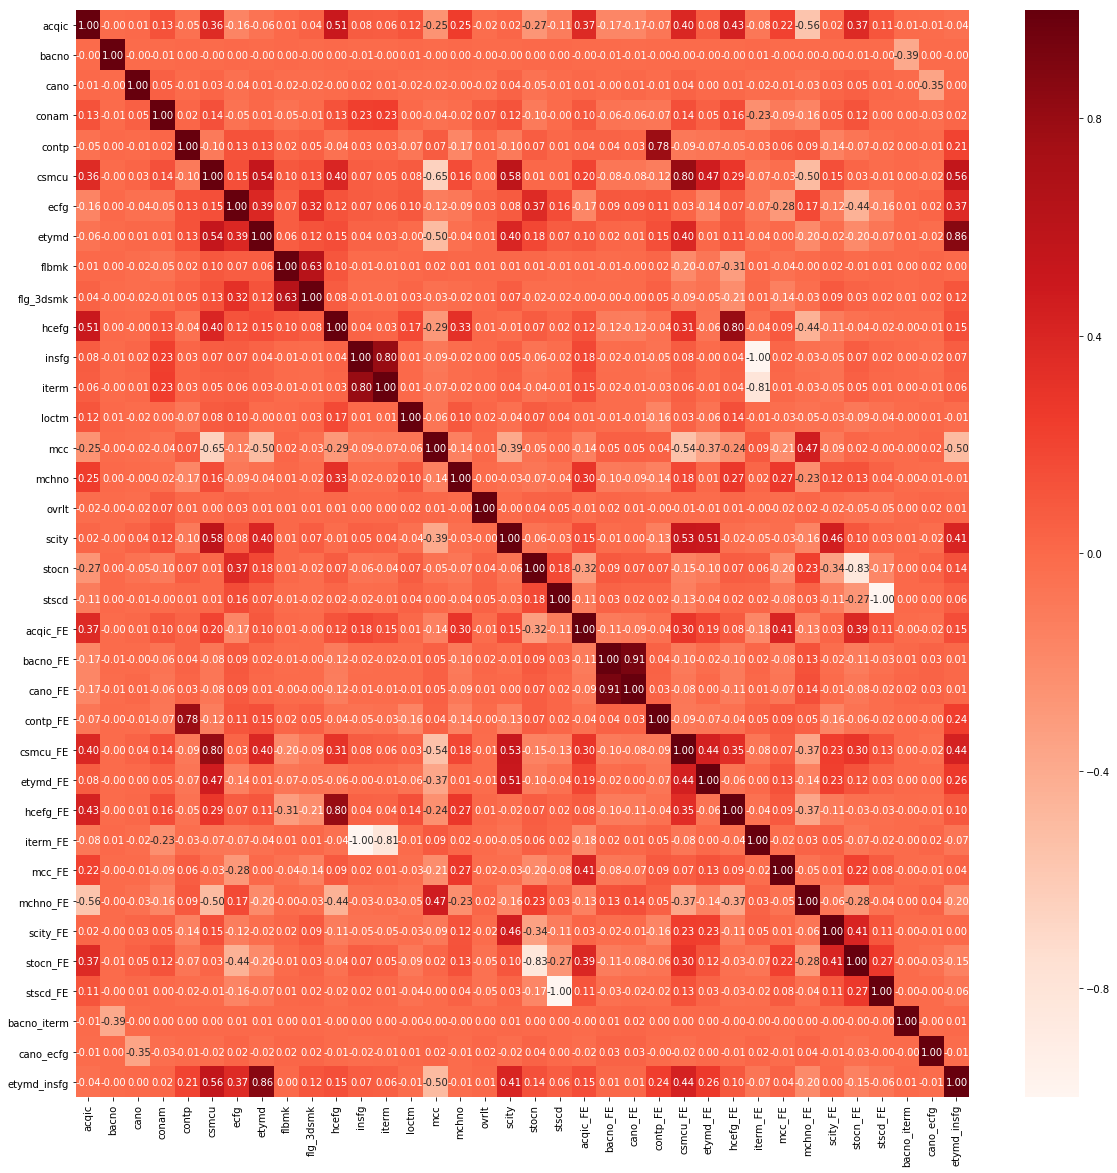

In [17]:
# 取出需要的特征
model1_features =  list(df.columns)
model1_features.remove('txkey')
model1_features.remove('locdt')

#############################
#model1_features.remove('flbmk')
#model1_features.remove('mcc')
#model1_features.remove('insfg')
#model1_features.remove('iterm')
##########################################
model1_features.remove('fraud_ind')
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
print(X_train.columns)
show_cor(X_train)

Fold 0
[0]	validation_0-auc:0.96269
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.97979
[200]	validation_0-auc:0.984089
[300]	validation_0-auc:0.985856
[400]	validation_0-auc:0.986803
[500]	validation_0-auc:0.987357
[600]	validation_0-auc:0.987681
[700]	validation_0-auc:0.987814
[800]	validation_0-auc:0.987855
[900]	validation_0-auc:0.987849
Stopping. Best iteration:
[757]	validation_0-auc:0.987887

  auc =  0.9878866128793753
  f1 =  0.6539524106585866
  confusion_matrix = 
 [[499783    488]
 [  3395   3669]]


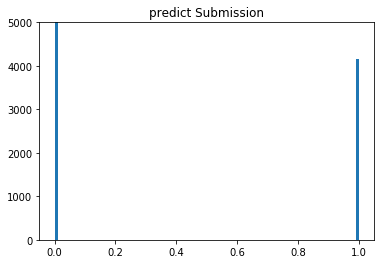

Fold 1
[0]	validation_0-auc:0.955377
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.97304
[200]	validation_0-auc:0.97871
[300]	validation_0-auc:0.982456
[400]	validation_0-auc:0.984136
[500]	validation_0-auc:0.98489
[600]	validation_0-auc:0.985473
[700]	validation_0-auc:0.985678
[800]	validation_0-auc:0.985864
[900]	validation_0-auc:0.985861
[1000]	validation_0-auc:0.985818
Stopping. Best iteration:
[843]	validation_0-auc:0.985897

  auc =  0.9858971994437697
  f1 =  0.648604566872055
  confusion_matrix = 
 [[499721    627]
 [  3251   3579]]


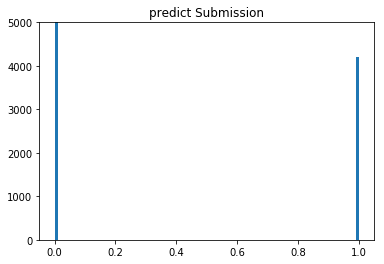

Fold 2
[0]	validation_0-auc:0.960465
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.978918
[200]	validation_0-auc:0.983786
[300]	validation_0-auc:0.985407
[400]	validation_0-auc:0.986366
[500]	validation_0-auc:0.986793
[600]	validation_0-auc:0.987132
[700]	validation_0-auc:0.987253
[800]	validation_0-auc:0.987338
[900]	validation_0-auc:0.987268
Stopping. Best iteration:
[767]	validation_0-auc:0.987356

  auc =  0.9873559365880767
  f1 =  0.6406144983197312
  confusion_matrix = 
 [[500195    618]
 [  3125   3336]]


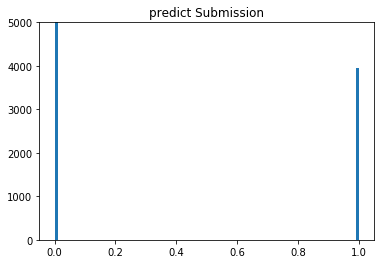

avg  auc =  0.9870465829704073
avg  f1 =  0.6477238252834576


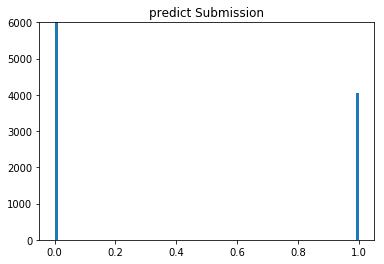

In [19]:
splits = 3
folds = GroupKFold(n_splits=splits)
#folds = KFold(n_splits = splits)
#folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
predictions = np.zeros(len(X_test))
split_groups = df['locdt'] #group
#split_groups = df['fraud_ind'] #startifiedkfold
f1_avg = 0
auc_avg = 0
#for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)): #kfold
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train,groups=split_groups)): #groupkfold and startifiedfold
    print("Fold {}".format(fold_))
    #train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    #valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]  
    train_df, y_train_df = X_train[model1_features].iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_df, y_valid_df =  X_train[model1_features].iloc[val_idx], Y_train.iloc[val_idx]  
        
    model = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )    
    model.fit(train_df, y_train_df,eval_set=[(valid_df,y_valid_df)],verbose=100, early_stopping_rounds=200)
  
    pred = model.predict_proba(valid_df)[:,1] 
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]
    print( "  f1 = ", f1_score(y_valid_df,y_pre))
    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df,y_pre))
    plt.hist(y_pre,bins=100)
    plt.ylim((0,5000))
    plt.title('predict Submission')
    plt.show() 
    auc_avg+= roc_auc_score(y_valid_df, pred)
    f1_avg+=f1_score(y_valid_df, y_pre)       
    # 显示结果
    predictions += model.predict_proba(X_test)[:,1]/ splits #model.predict_proba(X_test)[:,1]預測為1的機率    
predictions = [int(item>threshold) for  item in predictions]
print( "avg  auc = ", auc_avg/ splits )
print( "avg  f1 = ", f1_avg/ splits)
plt.hist(predictions,bins=100)
plt.ylim((0,6000))
plt.title('predict Submission')
plt.show()

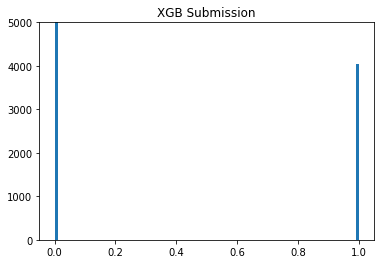

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 4041


In [20]:
# 结果保存
plt.hist(predictions,bins=100)
plt.ylim((0,5000))
plt.title('XGB Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = predictions
sampleSubmission.to_csv('submission_test.csv',index = None)

print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])